In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from datetime import datetime, timedelta
import seaborn as sns
import re
import nltk
import pickle

from sklearn.metrics import accuracy_score,roc_auc_score, f1_score, recall_score
from sklearn.metrics import  roc_curve, confusion_matrix, precision_score

from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split

from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer

# function to make n-grams
from nltk.util import ngrams 
from nltk import everygrams


from sklearn.feature_extraction.text import TfidfVectorizer

import warnings
warnings.filterwarnings('ignore') 
%matplotlib inline

# connection to the MySQL local database
import mysql.connector

# importing cusstom functions
from functions.custom_function_5 import tokenize_tweet
from functions.custom_function_5 import get_tokens_frequency_df
from functions.custom_function_5 import plot_word_cloud
from functions.custom_function_5 import clean_text
from functions.custom_function_5 import lemmatize_sentence

Using TensorFlow backend.


In [2]:
# increasing max length for all columns and number of columns
pd.set_option('display.max_colwidth', -1)
pd.set_option("display.max_columns", 50)

pd.set_option('display.max_info_columns', 500)
pd.set_option('display.max_rows', 500)

In the next cell, a connection with the local databse where all the fresh Tweets are stored is established.

In [3]:
db = mysql.connector.connect(
    host="localhost",
    user="root",
    passwd="password",
    database="twitter_2",
    charset = 'utf8'
 )


In [4]:
# check that it's connected
mycursor = db.cursor()
mycursor.execute("SHOW TABLES")

for x in mycursor:
    print(x)
    

('twitter_2',)


Here the present time and the delta of 300 minutes is created so that only Tweets from the last 300 minutes are pulled in the dataframe.

In [5]:
time_now = datetime.now()
time_now.strftime('%Y-%m-%d %H:%M:%S')

'2020-05-19 19:41:14'

In [6]:
time_10mins_before = timedelta(hours=0,minutes=300)
time_10mins_before

datetime.timedelta(seconds=18000)

In [7]:
time_interval = time_now - time_10mins_before
time_interval.strftime('%Y-%m-%d %H:%M:%S')

'2020-05-19 14:41:14'

In [8]:
# load data in the last 1 hour
query = "SELECT id_str, created_at, text, processed FROM twitter_2 WHERE created_at >= '{}'"     \
        .format(time_interval)

df = pd.read_sql(query, con=db)

In [9]:
# UTC for date time at default
df['created_at'] = pd.to_datetime(df['created_at'])

In [10]:
df.head(5)

,id_str,created_at,text,processed
0,1262797072639512576,2020-05-19 17:27:38,"RT @rtenews: Deputy Chief Medical Officer Dr @ronan_glynn tells @MorningIreland we will be living with #coronavirus ""for the foreseeable fu",-1
1,1262797072610193411,2020-05-19 17:27:38,REACTION TEST WITH MEDICINE BALL!!!\nDay 2 of the lockdown....12 more days to go. #stayhomestaysafe #coronavirus https://t.co/lTMXwDcqrz,-1
2,1262797076573892610,2020-05-19 17:27:39,RT @AJEnglish: Do we have to sacrifice our privacy to fight the #coronavirus? @AJStream discuss the robust debate over public health and di,-1
3,1262797076435537921,2020-05-19 17:27:39,"RT @RadioClydeNews: #coronavirus update from \n@NicolaSturgeon\n\n29 deaths since yesterday - takes total of confirmed COVID-19 deaths to 2,13",-1
4,1262797077047844864,2020-05-19 17:27:39,RT @AFP: VIDEO: 'This is the time for solidarity' - The European Union says it backs the World Health Organisation and multilateral efforts,-1


A separate function has been created so that all the preproccesing steps are also applied to the fresh Tweets.

In [11]:
df['text'] = df['text'].apply(clean_text)

In [12]:
# also getting rid of all words shorter than 3 characters
df['tweet_more_2_charac'] = df['text'].apply(lambda x: ' '.join([word for word in x.split() if len(word)>2]))

In [13]:
df.head(5)

,id_str,created_at,text,processed,tweet_more_2_charac
0,1262797072639512576,2020-05-19 17:27:38,RT Deputy Chief Medical Officer Dr tells we will be living with #coronavirus for the foreseeable fu,-1,Deputy Chief Medical Officer tells will living with #coronavirus for the foreseeable
1,1262797072610193411,2020-05-19 17:27:38,REACTION TEST WITH MEDICINE BALL Day of the lockdown more days to go #stayhomestaysafe #coronavirus,-1,REACTION TEST WITH MEDICINE BALL Day the lockdown more days #stayhomestaysafe #coronavirus
2,1262797076573892610,2020-05-19 17:27:39,RT Do we have to sacrifice our privacy to fight the #coronavirus discuss the robust debate over public health and di,-1,have sacrifice our privacy fight the #coronavirus discuss the robust debate over public health and
3,1262797076435537921,2020-05-19 17:27:39,RT #coronavirus update from deaths since yesterday takes total of confirmed COVID deaths to,-1,#coronavirus update from deaths since yesterday takes total confirmed COVID deaths
4,1262797077047844864,2020-05-19 17:27:39,RT VIDEO 'This is the time for solidarity' The European Union says it backs the World Health Organisation and multilateral efforts,-1,VIDEO 'This the time for solidarity' The European Union says backs the World Health Organisation and multilateral efforts



# Lemmatization with POS

Applying lemmatization exaclty in the same way it has been done for the original dataset.

In [14]:
df['lemmatized'] = df['tweet_more_2_charac'].apply(lambda x: lemmatize_sentence(x))

In [15]:
df.head(5)

,id_str,created_at,text,processed,tweet_more_2_charac,lemmatized
0,1262797072639512576,2020-05-19 17:27:38,RT Deputy Chief Medical Officer Dr tells we will be living with #coronavirus for the foreseeable fu,-1,Deputy Chief Medical Officer tells will living with #coronavirus for the foreseeable,Deputy Chief Medical Officer tell will live with # coronavirus for the foreseeable
1,1262797072610193411,2020-05-19 17:27:38,REACTION TEST WITH MEDICINE BALL Day of the lockdown more days to go #stayhomestaysafe #coronavirus,-1,REACTION TEST WITH MEDICINE BALL Day the lockdown more days #stayhomestaysafe #coronavirus,REACTION TEST WITH MEDICINE BALL Day the lockdown more day # stayhomestaysafe # coronavirus
2,1262797076573892610,2020-05-19 17:27:39,RT Do we have to sacrifice our privacy to fight the #coronavirus discuss the robust debate over public health and di,-1,have sacrifice our privacy fight the #coronavirus discuss the robust debate over public health and,have sacrifice our privacy fight the # coronavirus discuss the robust debate over public health and
3,1262797076435537921,2020-05-19 17:27:39,RT #coronavirus update from deaths since yesterday takes total of confirmed COVID deaths to,-1,#coronavirus update from deaths since yesterday takes total confirmed COVID deaths,# coronavirus update from death since yesterday take total confirm COVID death
4,1262797077047844864,2020-05-19 17:27:39,RT VIDEO 'This is the time for solidarity' The European Union says it backs the World Health Organisation and multilateral efforts,-1,VIDEO 'This the time for solidarity' The European Union says backs the World Health Organisation and multilateral efforts,VIDEO 'This the time for solidarity ' The European Union say back the World Health Organisation and multilateral effort


In [16]:
# getting rid of the ashtags
df['lemmatized_no_ash'] = df['lemmatized'].str.replace('# ', '')

In [17]:
df.head(5)

,id_str,created_at,text,processed,tweet_more_2_charac,lemmatized,lemmatized_no_ash
0,1262797072639512576,2020-05-19 17:27:38,RT Deputy Chief Medical Officer Dr tells we will be living with #coronavirus for the foreseeable fu,-1,Deputy Chief Medical Officer tells will living with #coronavirus for the foreseeable,Deputy Chief Medical Officer tell will live with # coronavirus for the foreseeable,Deputy Chief Medical Officer tell will live with coronavirus for the foreseeable
1,1262797072610193411,2020-05-19 17:27:38,REACTION TEST WITH MEDICINE BALL Day of the lockdown more days to go #stayhomestaysafe #coronavirus,-1,REACTION TEST WITH MEDICINE BALL Day the lockdown more days #stayhomestaysafe #coronavirus,REACTION TEST WITH MEDICINE BALL Day the lockdown more day # stayhomestaysafe # coronavirus,REACTION TEST WITH MEDICINE BALL Day the lockdown more day stayhomestaysafe coronavirus
2,1262797076573892610,2020-05-19 17:27:39,RT Do we have to sacrifice our privacy to fight the #coronavirus discuss the robust debate over public health and di,-1,have sacrifice our privacy fight the #coronavirus discuss the robust debate over public health and,have sacrifice our privacy fight the # coronavirus discuss the robust debate over public health and,have sacrifice our privacy fight the coronavirus discuss the robust debate over public health and
3,1262797076435537921,2020-05-19 17:27:39,RT #coronavirus update from deaths since yesterday takes total of confirmed COVID deaths to,-1,#coronavirus update from deaths since yesterday takes total confirmed COVID deaths,# coronavirus update from death since yesterday take total confirm COVID death,coronavirus update from death since yesterday take total confirm COVID death
4,1262797077047844864,2020-05-19 17:27:39,RT VIDEO 'This is the time for solidarity' The European Union says it backs the World Health Organisation and multilateral efforts,-1,VIDEO 'This the time for solidarity' The European Union says backs the World Health Organisation and multilateral efforts,VIDEO 'This the time for solidarity ' The European Union say back the World Health Organisation and multilateral effort,VIDEO 'This the time for solidarity ' The European Union say back the World Health Organisation and multilateral effort


Removing StopWords

In [18]:
# importing english stopwords
stop = stopwords.words('english')

df['tweet_low'] = df['lemmatized_no_ash'].apply(lambda x: x if type(x)!=str else x.lower())
df['tweet_without_stopwords'] = df['tweet_low'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))



In [19]:
df.head(5)

,id_str,created_at,text,processed,tweet_more_2_charac,lemmatized,lemmatized_no_ash,tweet_low,tweet_without_stopwords
0,1262797072639512576,2020-05-19 17:27:38,RT Deputy Chief Medical Officer Dr tells we will be living with #coronavirus for the foreseeable fu,-1,Deputy Chief Medical Officer tells will living with #coronavirus for the foreseeable,Deputy Chief Medical Officer tell will live with # coronavirus for the foreseeable,Deputy Chief Medical Officer tell will live with coronavirus for the foreseeable,deputy chief medical officer tell will live with coronavirus for the foreseeable,deputy chief medical officer tell live coronavirus foreseeable
1,1262797072610193411,2020-05-19 17:27:38,REACTION TEST WITH MEDICINE BALL Day of the lockdown more days to go #stayhomestaysafe #coronavirus,-1,REACTION TEST WITH MEDICINE BALL Day the lockdown more days #stayhomestaysafe #coronavirus,REACTION TEST WITH MEDICINE BALL Day the lockdown more day # stayhomestaysafe # coronavirus,REACTION TEST WITH MEDICINE BALL Day the lockdown more day stayhomestaysafe coronavirus,reaction test with medicine ball day the lockdown more day stayhomestaysafe coronavirus,reaction test medicine ball day lockdown day stayhomestaysafe coronavirus
2,1262797076573892610,2020-05-19 17:27:39,RT Do we have to sacrifice our privacy to fight the #coronavirus discuss the robust debate over public health and di,-1,have sacrifice our privacy fight the #coronavirus discuss the robust debate over public health and,have sacrifice our privacy fight the # coronavirus discuss the robust debate over public health and,have sacrifice our privacy fight the coronavirus discuss the robust debate over public health and,have sacrifice our privacy fight the coronavirus discuss the robust debate over public health and,sacrifice privacy fight coronavirus discuss robust debate public health
3,1262797076435537921,2020-05-19 17:27:39,RT #coronavirus update from deaths since yesterday takes total of confirmed COVID deaths to,-1,#coronavirus update from deaths since yesterday takes total confirmed COVID deaths,# coronavirus update from death since yesterday take total confirm COVID death,coronavirus update from death since yesterday take total confirm COVID death,coronavirus update from death since yesterday take total confirm covid death,coronavirus update death since yesterday take total confirm covid death
4,1262797077047844864,2020-05-19 17:27:39,RT VIDEO 'This is the time for solidarity' The European Union says it backs the World Health Organisation and multilateral efforts,-1,VIDEO 'This the time for solidarity' The European Union says backs the World Health Organisation and multilateral efforts,VIDEO 'This the time for solidarity ' The European Union say back the World Health Organisation and multilateral effort,VIDEO 'This the time for solidarity ' The European Union say back the World Health Organisation and multilateral effort,video 'this the time for solidarity ' the european union say back the world health organisation and multilateral effort,video 'this time solidarity ' european union say back world health organisation multilateral effort


# Vectorizing TF-IDF for Fresh Tweets for Logistic Regression

In this instance, the only-fitted tf-idf object is recalled with pickle. In this way, the same matrix with 9000 columns is used to transform the new batch of words. This is necessary in orer for the model to be able to make predictins on unseen text. Unfortunately, new words are simpy ignored and not included in the vectorised matrix.

In [20]:
tf_idf_fit_only = pickle.load( open("tfidf_pickle_fit", "rb" ))

In [21]:
matrix =tf_idf_fit_only.transform(df['tweet_without_stopwords'])

In [22]:
# vectorising the new tweets
df_vector = pd.DataFrame(matrix.todense(),columns = tf_idf_fit_only.get_feature_names())

In [23]:
df_vector.head(5)

,aap,aaron,abandon,abc,ability,able,abo,absolute,absolutely,absolutely love,abt,abundance,abuse,abusive,academy,acc,accent,accept,accept fact,acceptable,access,accessory,accident,accidentally,accord,...,youre,yous,youth,youtube,youtube video,youtuber,youuu,yoy,yrs,yum,yummy,yung,yup,yyc,zealand,zebra,zelda,zen,zero,zimmerman,zip,zoe,zombie,zone,zoo
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**I am having problems recalling the correct pickled model I want to use. The following sections are still very much in progress but it is just to show that there is a functioning pipeline in place to process new tweets.**

In [24]:
# import pickled logistic regression
model_log = pickle.load(open("pickled_logistic", "rb" ))
model_log

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [25]:
# model_1 = pickle.load(open('pickled_logistic_1', "rb"))
# model_1

In [26]:
y_hat_fresh =  model_log.predict_proba(df_vector)
predictions = y_hat_fresh[:,1]
predictions [:10]


array([0.78464243, 0.94392716, 0.8546424 , 0.90359324, 0.93418332,
       0.88833965, 0.88789201, 0.85750869, 0.75423733, 0.8907822 ])

In [27]:
final_res =[]
for x in predictions:
    if x >.3:
        final_res.append(1)
    else:
        final_res.append(0)
final_res
len(final_res)



419

In [28]:
df['predictions'] = pd.Series(final_res)


In [29]:
df.head(15)

,id_str,created_at,text,processed,tweet_more_2_charac,lemmatized,lemmatized_no_ash,tweet_low,tweet_without_stopwords,predictions
0,1262797072639512576,2020-05-19 17:27:38,RT Deputy Chief Medical Officer Dr tells we will be living with #coronavirus for the foreseeable fu,-1,Deputy Chief Medical Officer tells will living with #coronavirus for the foreseeable,Deputy Chief Medical Officer tell will live with # coronavirus for the foreseeable,Deputy Chief Medical Officer tell will live with coronavirus for the foreseeable,deputy chief medical officer tell will live with coronavirus for the foreseeable,deputy chief medical officer tell live coronavirus foreseeable,1
1,1262797072610193411,2020-05-19 17:27:38,REACTION TEST WITH MEDICINE BALL Day of the lockdown more days to go #stayhomestaysafe #coronavirus,-1,REACTION TEST WITH MEDICINE BALL Day the lockdown more days #stayhomestaysafe #coronavirus,REACTION TEST WITH MEDICINE BALL Day the lockdown more day # stayhomestaysafe # coronavirus,REACTION TEST WITH MEDICINE BALL Day the lockdown more day stayhomestaysafe coronavirus,reaction test with medicine ball day the lockdown more day stayhomestaysafe coronavirus,reaction test medicine ball day lockdown day stayhomestaysafe coronavirus,1
2,1262797076573892610,2020-05-19 17:27:39,RT Do we have to sacrifice our privacy to fight the #coronavirus discuss the robust debate over public health and di,-1,have sacrifice our privacy fight the #coronavirus discuss the robust debate over public health and,have sacrifice our privacy fight the # coronavirus discuss the robust debate over public health and,have sacrifice our privacy fight the coronavirus discuss the robust debate over public health and,have sacrifice our privacy fight the coronavirus discuss the robust debate over public health and,sacrifice privacy fight coronavirus discuss robust debate public health,1
3,1262797076435537921,2020-05-19 17:27:39,RT #coronavirus update from deaths since yesterday takes total of confirmed COVID deaths to,-1,#coronavirus update from deaths since yesterday takes total confirmed COVID deaths,# coronavirus update from death since yesterday take total confirm COVID death,coronavirus update from death since yesterday take total confirm COVID death,coronavirus update from death since yesterday take total confirm covid death,coronavirus update death since yesterday take total confirm covid death,1
4,1262797077047844864,2020-05-19 17:27:39,RT VIDEO 'This is the time for solidarity' The European Union says it backs the World Health Organisation and multilateral efforts,-1,VIDEO 'This the time for solidarity' The European Union says backs the World Health Organisation and multilateral efforts,VIDEO 'This the time for solidarity ' The European Union say back the World Health Organisation and multilateral effort,VIDEO 'This the time for solidarity ' The European Union say back the World Health Organisation and multilateral effort,video 'this the time for solidarity ' the european union say back the world health organisation and multilateral effort,video 'this time solidarity ' european union say back world health organisation multilateral effort,1
5,1262797078956294144,2020-05-19 17:27:39,RT Trump undoubtedly NOT taking this drug Demonstrated harmful medical effects Might kill him Definitely will promote dang,-1,Trump undoubtedly NOT taking this drug Demonstrated harmful medical effects Might kill him Definitely will promote dang,Trump undoubtedly NOT take this drug Demonstrated harmful medical effect Might kill him Definitely will promote dang,Trump undoubtedly NOT take this drug Demonstrated harmful medical effect Might kill him Definitely will promote dang,trump undoubtedly not take this drug demonstrated harmful medical effect might kill him definitely will promote dang,trump undoubtedly take drug demonstrated harmful medical effect might kill definitely promote dang,1
6,1262797079132413963,2020-05-19 17:27:39,RT Pope Our Duty is to obey the United Nations The 

# CNN for Fresh Tweets

In [30]:
# cnn = pickle.load( open("pickle_cnn", "rb" ) )

In [31]:
# df['tokenized'] = df['lemmatized_no_ash'].apply(tokenize_tweet)

In [32]:
# df

In [33]:
# # Some variables that will be used throughout the modeling process
# num_words = 20000 # The max number of words in our vocabulary
# epochs = 10  
# batch_size = 64  
# sequence_len = 200  # Maximum number of words in a sequence
# embedding_dimensions = 200  # Number of dimensions of the trainable embedding layer

In [34]:
# tk = Tokenizer(num_words=num_words, # The 20000 most important words for our vocabulary
#                filters='!"#$%&()*+,-./:;<=>?@[\]^_`{"}~\t\n', # Regex that will prune off non alphabetical characters
#                lower=True, # Lowercase the text data for consistency
#                split=" ")
# tk.fit_on_texts(df['tokenized']) # Fit on our training set
# X_train_seq = tk.texts_to_sequences(df['tokenized']) # Indexed sequences based on fitted tokenizer


In [35]:
# X_train_seq_pad = pad_sequences(X_train_seq, maxlen=23) # Padding the sequences so that they are all the same length


In [36]:
# predictions = cnn.predict(X_train_seq_pad)[:,0]

In [37]:
# len(predictions)

In [38]:
# predictions

# Naive Bayes for Fresh Tweets

In [39]:
# cv = pickle.load(open("CVBayes", "rb" ))

In [40]:
# bayes = pickle.load(open("BayesModel", "rb" ))

In [41]:
# docs_new = df['lemmatized_no_ash']
# x_new_counts = cv.transform(docs_new).toarray()
# bayes.predict_proba(x_new_counts)

In [42]:
# x_new_counts.shape

# WordCount and Negative Tweets Highlight

In [43]:
# Clean and transform data to enable time series
result = df.groupby(                                        \
      [pd.Grouper(key='created_at', freq='2s'), 'predictions'] \
    ).count().unstack().stack().reset_index()

result = result.rename(columns=    { "id_str": "Num of 'Coronavirus' mentions",  \
      "created_at": "Time" })

In [44]:
result.head(5)


,Time,predictions,Num of 'Coronavirus' mentions,text,processed,tweet_more_2_charac,lemmatized,lemmatized_no_ash,tweet_low,tweet_without_stopwords
0,2020-05-19 17:27:38,1,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0
1,2020-05-19 17:27:40,1,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0
2,2020-05-19 17:27:42,1,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0
3,2020-05-19 17:27:44,1,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0
4,2020-05-19 17:27:46,1,11.0,11.0,11.0,11.0,11.0,11.0,11.0,11.0


In [45]:
df['tokenized'] = df['tweet_without_stopwords'].apply(tokenize_tweet)

In [46]:
counts = get_tokens_frequency_df(df['tokenized'])
counts = counts.sort_values(by='token_count', ascending = False)
counts = counts[:10]


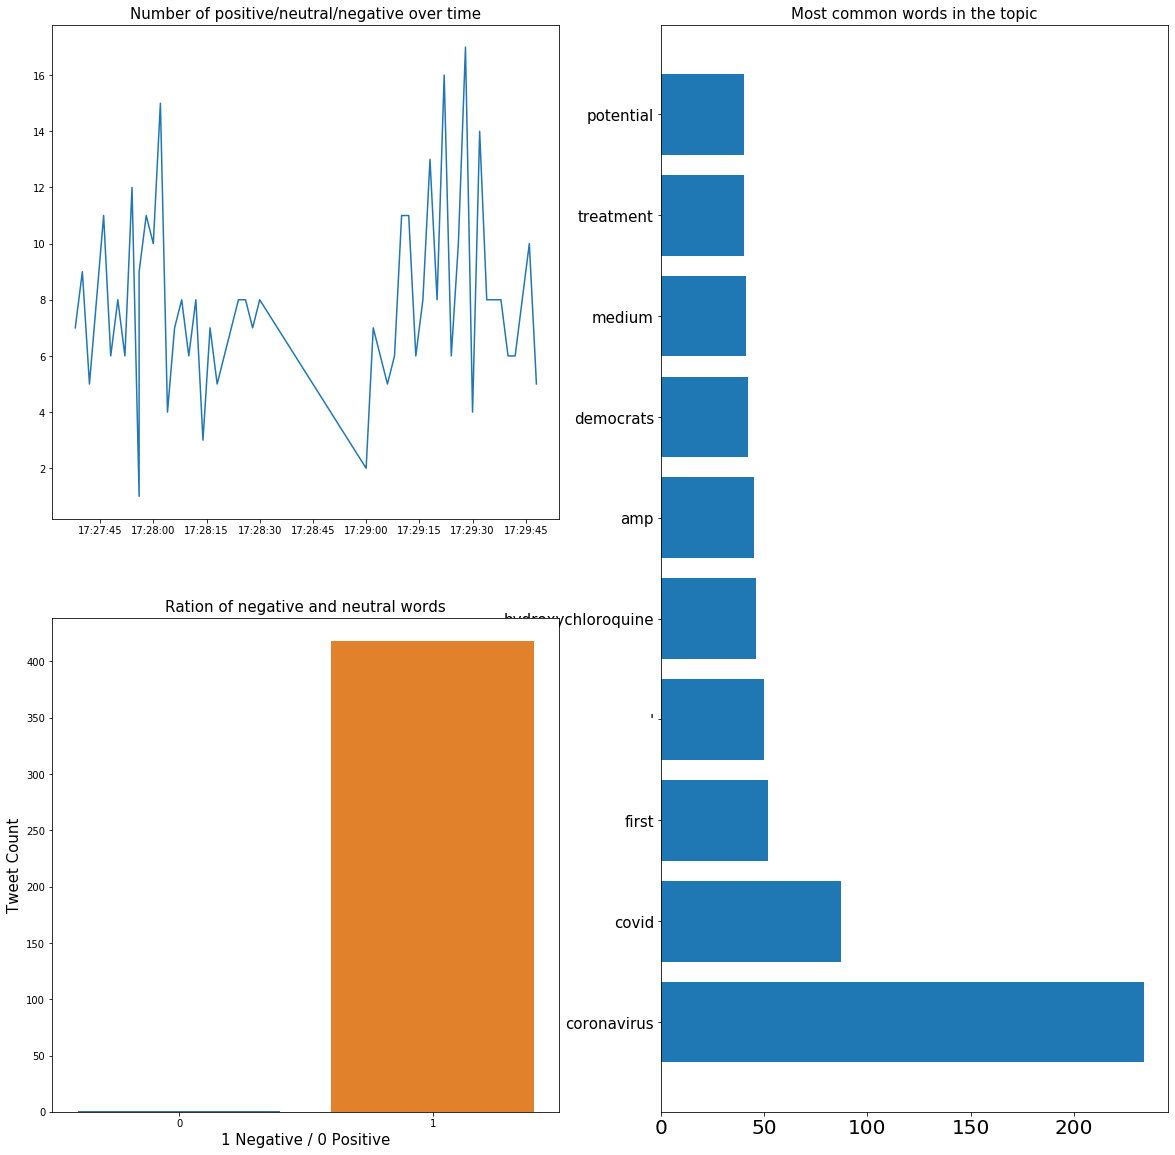

In [47]:
fig, axes = plt.subplots(2,2, figsize = (20,20))


ax1 = plt.subplot(221)
plt.title('Number of positive/neutral/negative over time', fontsize = 15)

ax1 = plt.plot(result['Time'], (result["Num of 'Coronavirus' mentions"]))
# ax1 = plt.plot(result['created_at'], (result['predictions']==1))

ax2 = plt.subplot(122)
plt.title('Most common words in the topic', fontsize = 15)
plt.xticks(fontsize= 20)
plt.yticks(fontsize = 15)
ax2 = plt.barh(counts['token'], counts['token_count'])

ax3 = plt.subplot(223)
plt.title('Ration of negative and neutral words', fontsize = 15)
plt.xlabel('1 Negative / 0 Positive', fontsize = 15)
plt.ylabel('Tweet Count', fontsize = 15)
predictions = df['predictions'].value_counts()
sns.barplot(predictions.index, predictions.values)

plt.show()
